# Using TextVectorization Layer

Deep learning models, being differentiable functions, can only process numeric tensors: they can’t take raw text as input. Vectorizing text is the process of transforming
text into numeric tensors. Text vectorization processes come in many shapes and
forms, but they all follow the same template :

 First, you standardize the text to make it easier to process, such as by converting
it to lowercase or removing punctuation.

 You split the text into units (called tokens), such as characters, words, or groups
of words. This is called tokenization.

 You convert each such token into a numerical vector. This will usually involve
first indexing all tokens present in the data.

Every step I’ve introduced so far would be very easy to implement in pure Python.


In [ ]:
import string
class Vectorizer:
 def standardize(self, text):
    text = text.lower()
    return "".join(char for char in text if char not in string.punctuation)

 def tokenize(self, text):
    text = self.standardize(text)
    return text.split()

 def make_vocabulary(self, dataset):
    self.vocabulary = {"": 0, "[UNK]": 1}
    for text in dataset:
      text = self.standardize(text)
      tokens = self.tokenize(text)
      for token in tokens:
        if token not in self.vocabulary:
          self.vocabulary[token] = len(self.vocabulary)
    self.inverse_vocabulary = dict((v, k) for k, v in self.vocabulary.items())

 def encode(self, text):
    text = self.standardize(text)
    tokens = self.tokenize(text)
    return [self.vocabulary.get(token, 1) for token in tokens]

 def decode(self, int_sequence):
    return " ".join(self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

In [ ]:
vectorizer = Vectorizer()
dataset = [
 "I write, erase, rewrite",
 "Erase again, and then",
 "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [ ]:
print(vectorizer.vocabulary)

{'': 0, '[UNK]': 1, 'i': 2, 'write': 3, 'erase': 4, 'rewrite': 5, 'again': 6, 'and': 7, 'then': 8, 'a': 9, 'poppy': 10, 'blooms': 11}


In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"

In [ ]:
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [ ]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


However, using something like this wouldn’t be very performant. In practice, you’ll
work with the Keras TextVectorization layer, which is fast and efficient and can be
dropped directly into a tf.data pipeline or a Keras model.

[What are Tensors and why they are used?](https://chat.openai.com/share/99048956-5c7f-4744-9802-ff77e0241905)

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode="int",) # Configures the layer to return sequences of words encoded as integer indices. There are several other output modes available

By default, the TextVectorization layer will use the setting “convert to lowercase and
remove punctuation” for text standardization, and “split on whitespace” for tokenization.

But importantly, you can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. Note that
such custom functions should operate on tf.string tensors, not regular Python
strings!

 For instance, the default layer behavior is equivalent to the following:

In [ ]:
import re
import string
import tensorflow as tf
def custom_standardization_fn(string_tensor):
 lowercase_string = tf.strings.lower(string_tensor) # Convert strings to lowercase.
 return tf.strings.regex_replace(lowercase_string, f"[{re.escape(string.punctuation)}]", "") # Replace punctuation characters with the empty string.

def custom_split_fn(string_tensor):
 return tf.strings.split(string_tensor) # Split strings on whitespace.


text_vectorization = TextVectorization(
 output_mode="int",
 standardize=custom_standardization_fn,
 split=custom_split_fn,
)

To index the vocabulary of a text corpus, just call the adapt() method of the layer
with a Dataset object that yields strings, or just with a list of Python strings

In [ ]:
dataset = [
 "I write, erase, rewrite",
 "Erase again, and then",
 "A poppy blooms.",
]
text_vectorization.adapt(dataset)

Note that you can retrieve the computed vocabulary via get_vocabulary()—this can
be useful if you need to convert text encoded as integer sequences back into words.
The first two entries in the vocabulary are the mask token (index 0) and the OOV
token (index 1). Entries in the vocabulary list are sorted by frequency, so with a realworld dataset, very common words like “the” or “a” would come first.

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

In [ ]:
vocabulary = text_vectorization.get_vocabulary()

# Test sentence
test_sentence = "I write, rewrite, and still rewrite again"

# Encode the test sentence
encoded_sentence = text_vectorization(test_sentence)

# Print the encoded sentence
print(encoded_sentence)

# Create an inverse vocabulary mapping
inverse_vocab = dict(enumerate(vocabulary))

# Decode the encoded sentence
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)

# Print the decoded sentence
print(decoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)
i write rewrite and [UNK] rewrite again


[Word respresentations in ML](https://chat.openai.com/share/07c02eb3-c1ad-45c9-8bc7-094899f3e793)

[Word order in Transformners ](https://chat.openai.com/share/5c5cd13c-b8a0-41c5-a0b5-15863961bcac)

# IMDB Movie Review

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  32.1M      0  0:00:02  0:00:02 --:--:-- 32.1M


You’re left with a directory named aclImdb, with the following structure:

aclImdb/

...train/

......pos/

......neg/

...test/

......pos/

......neg/

For instance, the train/pos/ directory contains a set of 12,500 text files, each of which
contains the text body of a positive-sentiment movie review to be used as training data.
The negative-sentiment reviews live in the “neg” directories. In total, there are 25,000
text files for training and another 25,000 for testing.

There’s also a train/unsup subdirectory in there, which we don’t need. Let’s
delete it:

In [ ]:
!rm -r aclImdb/train/unsup

Take a look at the content of a few of these text files. Whether you’re working with
text data or image data, remember to always inspect what your data looks like before
you dive into modeling it. It will ground your intuition about what your model is actually doing:

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Next, let’s prepare a validation set by setting apart 20% of the training text files in a
new directory, aclImdb/val

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
 os.makedirs(val_dir / category)
 files = os.listdir(train_dir / category)
 random.Random(1337).shuffle(files) # Shuffle the list of training files using a seed, to ensure we get the same validation set every time we run the code.
 num_val_samples = int(0.2 * len(files))
 val_files = files[-num_val_samples:]
 for fname in val_files:
    shutil.move(train_dir / category / fname,val_dir / category / fname)

You can
do the exact same thing for text files using the text_dataset_from_directory utility.
Let’s create three Dataset objects for training, validation, and testing

In [ ]:
from tensorflow import keras
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'Moe and Larry are newly henpecked husbands, having married Shemp\'s demanding sisters. At his music studio, Shemp learns he will inherit a fortune if he marries someone himself! <br /><br />"Husbands Beware" is a remake of 1947\'s "Brideless Groom," widely considered by many to be one of the best Stooge films with Shemp. The remake contains most of the footage from that film. The new scenes, shot May 17, 1955, include the storyline of Moe and Larry marrying Shemp\'s sisters, along with their cooking of a turkey laced with turpentine! A few new scenes are tacked onto the end of the film as well(a double for Dee Green was used; if you blink, you will miss the double\'s appearance.) <br /><br />"Husbands Beware" would have made for a good film with just the plot line of marrying the sisters. Budget considerations, coupled with fewer bookings for two-reel comedies

# Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning
model is to discard order and treat it as a set (a “bag”) of tokens. You could either look
at individual words (unigrams), or try to recover some local order information by
looking at groups of consecutive token (N-grams).

# SINGLE WORDS (UNIGRAMS) WITH BINARY ENCODING


If you use a bag of single words, the sentence “the cat sat on the mat” becomes
{"cat", "mat", "on", "sat", "the"}

The main advantage of this encoding is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word.

 For instance,
using binary encoding (multi-hot), you’d encode a text as a vector with as many
dimensions as there are words in your vocabulary—with 0s almost everywhere and
some 1s for dimensions that encode words present in the text.

[Single Unigram , it's advantages and binary encoding](https://chat.openai.com/share/ef00b623-71a1-4c71-9760-af1515436016)

First, let’s process our raw text datasets with a TextVectorization layer so that
they yield multi-hot encoded binary word vectors. Our layer will only look at single
words (that is to say, unigrams).

In [ ]:
# Limit the vocabulary to the 20,000 most frequent words. Otherwise we’d be indexing every word in the training data— potentially tens of thousands of terms that only occur once or
# twice and thus aren’t informative. In general, 20,000 is the right vocabulary size for text classification.

text_vectorization = TextVectorization(
 max_tokens=20000,
 output_mode="multi_hot", # Encode the output tokens as multi-hot binary vectors.
)

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x) # Prepare a dataset that only yields raw text inputs (no labels).

In [ ]:
# Take one element from the dataset
sample_data = next(iter(text_only_train_ds.take(1)))

# Print the sample data
print(sample_data)

tf.Tensor(
[b"This film tells the story of a romance between Albert Einstien niece and a gas station attendant. In order to get the two together, Einstien agrees to help Ed(Hudsucker Proxy's Tim Robbins) learn to act more intelligent. This impresses Catherine (Meg Ryan). Unfortunately Einstien goes too far and Ed is considered to be a genius. Hilarity ensues. Not to be missed. Filmed in Mercer county New Jersey at Princeton University, Lawrenceville Prep School (doubling for Princeton University) as well as a beautiful vintage gas station in Hopewell."
 b'New York City houses one man above all others, the possibly immortal Dr. Anton Mordrid. Mordrid is the sworn protector of humanity, using his magical powers to keep his brother and rival, Kabal, chained up so that he may not enslave the human race. Well, wouldn\'t you know it? A prophesy comes true and Kabal breaks free, and begins collecting elements (including platinum and uranium) for his alchemy experiments. With the help of a pol

In [ ]:
text_vectorization.adapt(text_only_train_ds)

In [ ]:
# Prepare processed versions of our training, validation, and test dataset.

binary_1gram_train_ds = train_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break


inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dropout(0.5)(x)
 outputs = layers.Dense(1, activation="sigmoid")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
 return model

In [ ]:
model = get_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("binary_1gram.keras",
 save_best_only=True)
]

"""
We call cache() on the
datasets to cache them in
memory: this way, we will
only do the preprocessing
once, during the first
epoch, and we’ll reuse the
preprocessed texts for the
following epochs. This can
only be done if the data
is small enough to fit in
memory
"""

history = model.fit(binary_1gram_train_ds.cache(),
validation_data=binary_1gram_val_ds.cache(),
 epochs=10,
 callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.2316 - accuracy: 0.9213 - val_loss: 0.3004 - val_accuracy: 0.8934
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2176 - accuracy: 0.9298 - val_loss: 0.3131 - val_accuracy: 0.8954
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2124 - accuracy: 0.9305 - val_loss: 0.3259 - val_accuracy: 0.8852
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2058 - accuracy: 0.9346 - val_loss: 0.3350 - val_accuracy: 0.8916
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2050 - accuracy: 0.9361 - val_loss: 0.3439 - val_accuracy: 0.8908
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2039 - accuracy: 0.9387 - val_loss: 0.3562 - val_accuracy: 0.8848
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2109 - accuracy: 0.9390 - val_loss: 0.3619 - val_accuracy: 0.8866
Epoc

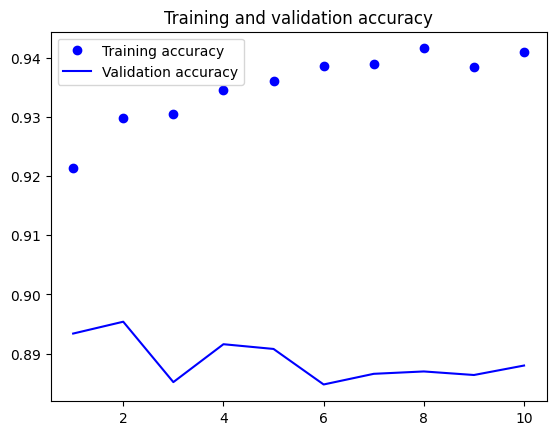

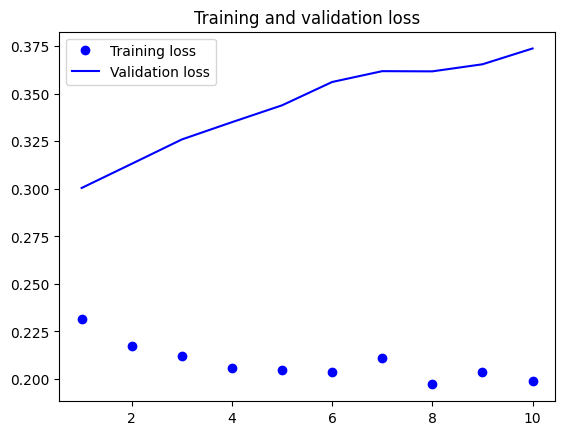

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.2995 - accuracy: 0.8872
Test acc: 0.887


This gets us to a test accuracy of 88.7%: not bad! Note that in this case, since the dataset is a balanced two-class classification dataset (there are as many positive samples as
negative samples), the “naive baseline” we could reach without training an actual model
would only be 50%.

# BIGRAMS WITH BINARY ENCODING

Of course, discarding word order is very reductive, because even atomic concepts can
be expressed via multiple words: the term “United States” conveys a concept that is
quite distinct from the meaning of the words “states” and “united” taken separately.
For this reason, you will usually end up re-injecting local order information into your
bag-of-words representation by looking at N-grams rather than single words (most
commonly, bigrams).


With bigrams, our sentence becomes

{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}

The TextVectorization layer can be configured to return arbitrary N-grams: bigrams,
trigrams, etc. Just pass an **ngrams=N** argument as in the following listing.

In [ ]:
text_vectorization = TextVectorization(
 ngrams=2,
 max_tokens=20000,
 output_mode="multi_hot",
)

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

In [ ]:
model = get_model()
model.summary()
callbacks = [
 keras.callbacks.ModelCheckpoint("binary_2gram.keras",
 save_best_only=True)
]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(binary_2gram_train_ds.cache(),
 validation_data=binary_2gram_val_ds.cache(),
 epochs=10,
 callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3868 - accuracy: 0.8371 - val_loss: 0.2689 - val_accuracy: 0.8952
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2500 - accuracy: 0.9118 - val_loss: 0.2617 - val_accuracy: 0.9034
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2136 - accuracy: 0.9287 - val_loss: 0.2797 - val_accuracy: 0.9040
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2093 - accuracy: 0.9368 - val_loss: 0.2928 - val_accuracy: 0.9034
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1885 - accuracy: 0.9436 - val_loss: 0.3199 - val_accuracy: 0.9008
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1819 - accuracy: 0.9463 - val_loss: 0.3315 - val_accuracy: 0.8916
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1784 - accuracy: 0.9488 - val_loss: 0.3506 - val_accuracy: 0.8948
Epoc

In [ ]:
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 5s 6ms/step - loss: 0.2687 - accuracy: 0.8999
Test acc: 0.900


We’re now getting 90% test accuracy, a marked improvement! Turns out local order
is pretty important.

# BIGRAMS WITH TF-IDF ENCODING

You can also add a bit more information to this representation by counting how many
times each word or N-gram occurs, that is to say, by taking the histogram of the words
over the text:

{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
 "sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}

If you’re doing text classification, knowing how many times a word occurs in a sample
is critical: any sufficiently long movie review may contain the word “terrible” regardless of sentiment, but a review that contains many instances of the word “terrible” is
likely a negative one.

In [ ]:
text_vectorization = TextVectorization(
 ngrams=2,
 max_tokens=20000,
 output_mode="count"
)

Now, of course, some words are bound to occur more often than others no matter
what the text is about. The words “the,” “a,” “is,” and “are” will always dominate your
word count histograms, drowning out other words—despite being pretty much useless
features in a classification context. How could we address this?

You already guessed it: via normalization. We could just normalize word counts by
subtracting the mean and dividing by the variance (computed across the entire training dataset). That would make sense. Except most vectorized sentences consist almost
entirely of zeros (our previous example features 12 non-zero entries and 19,988 zero
entries), a property called “sparsity.” That’s a great property to have, as it dramatically
reduces compute load and reduces the risk of overfitting. If we subtracted the mean
from each feature, we’d wreck sparsity. Thus, whatever normalization scheme we use
should be divide-only. What, then, should we use as the denominator? The best practice is to go with something called TF-IDF normalization—TF-IDF stands for “term frequency, inverse document frequency.”

TF-IDF is so common that it’s built into the TextVectorization layer. All you need
to do to start using it is to switch the output_mode argument to "tf_idf".

In [ ]:
text_vectorization = TextVectorization(
 ngrams=2,
 max_tokens=20000,
 output_mode="tf_idf",
)

In [ ]:
text_vectorization.adapt(text_only_train_ds) # The adapt() call will learn the TF-IDF weights in addition to the vocabulary.
tfidf_2gram_train_ds = train_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

In [ ]:
model = get_model()
model.summary()
callbacks = [
 keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
 save_best_only=True)
]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(tfidf_2gram_train_ds.cache(),
 validation_data=tfidf_2gram_val_ds.cache(),
 epochs=10,
 callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.4763 - accuracy: 0.7796 - val_loss: 0.3043 - val_accuracy: 0.8774
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3338 - accuracy: 0.8615 - val_loss: 0.2818 - val_accuracy: 0.8902
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2975 - accuracy: 0.8776 - val_loss: 0.2878 - val_accuracy: 0.8982
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2698 - accuracy: 0.8906 - val_loss: 0.2983 - val_accuracy: 0.8838
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2494 - accuracy: 0.8962 - val_loss: 0.3247 - val_accuracy: 0.8716
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2404 - accuracy: 0.9011 - val_loss: 0.3231 - val_accuracy: 0.8758
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2282 - accuracy: 0.9035 - val_loss: 0.3343 - val_accuracy: 0.8772
Epoc

In [ ]:
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 6s 7ms/step - loss: 0.2849 - accuracy: 0.8866
Test acc: 0.887


This gets us an 88.7% test accuracy on the IMDB classification task: it doesn’t seem to
be particularly helpful in this case.

However, for many text-classification datasets, it
would be typical to see a one-percentage-point increase when using TF-IDF compared
to plain binary encoding.

# Processing words as a sequence: The sequence model approach

To implement a sequence model, you’d start by representing your input samples as
sequences of integer indices (one integer standing for one word). Then, you’d map
each integer to a vector to obtain vector sequences. Finally, you’d feed these
sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or a Transformer

[How sequence models work with example and explanation of above thing](https://chat.openai.com/share/c011049a-80a3-491a-9f28-c01735eaad82)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
"""
In order to keep a manageable
input size, we’ll truncate the
inputs after the first 600 words.
This is a reasonable choice, since
the average review length is 233
words, and only 5% of reviews
are longer than 600 words.
"""


max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
 max_tokens=max_tokens,
 output_mode="int",
 output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

[Max tokens and max length , meaning and usage](https://chat.openai.com/share/24714764-300b-48d2-a378-21ea65f1c522)

In [ ]:
int_train_ds = train_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
int_val_ds = val_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)
int_test_ds = test_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

The simplest way to convert our integer sequences to vector
sequences is to one-hot encode the integers (each dimension would represent one
possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple
bidirectional LSTM.

In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64") # One input is a sequence of integers.
embedded = tf.one_hot(inputs, depth=max_tokens) # Encode the integers into binary 20,000-dimensional vectors.
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Finally, add a classification layer.
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                5128448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
 save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
 callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 172s 263ms/step - loss: 0.5604 - accuracy: 0.7176 - val_loss: 0.3477 - val_accuracy: 0.8620
Epoch 2/10
625/625 [==============================] - 165s 265ms/step - loss: 0.3629 - accuracy: 0.8637 - val_loss: 0.3090 - val_accuracy: 0.8792
Epoch 3/10
625/625 [==============================] - 164s 263ms/step - loss: 0.2981 - accuracy: 0.8943 - val_loss: 0.2786 - val_accuracy: 0.8928
Epoch 4/10
625/625 [==============================] - 164s 262ms/step - loss: 0.2510 - accuracy: 0.9144 - val_loss: 0.3003 - val_accuracy: 0.8742
Epoch 5/10
625/625 [==============================] - 162s 259ms/step - loss: 0.2251 - accuracy: 0.9247 - val_loss: 0.3026 - val_accuracy: 0.8860
Epoch 6/10
625/625 [==============================] - 163s 261ms/step - loss: 0.2001 - accuracy: 0.9351 - val_loss: 0.3028 - val_accuracy: 0.8906
Epoch 7/10
625/625 [==============================] - 164s 262ms/step - loss: 0.1775 - accuracy: 0.9417 - val_loss: 0.3509 -

In [ ]:
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 99s 124ms/step - loss: 0.2965 - accuracy: 0.8829
Test acc: 0.883


A first observation: this model trains very slowly, especially compared to the lightweight model of the previous section.

 This is because our inputs are quite large: each
input sample is encoded as a matrix of size (600, 20000) (600 words per sample,
20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do.

 Second, the model only gets to 88% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model.

Clearly, using one-hot encoding to turn words into vectors, which was the simplest
thing we could do, wasn’t a great idea. There’s a better way: word embeddings.

Let’s look at how to use such an embedding space in practice. There are two ways
to obtain word embeddings:


 Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the
weights of a neural network.


 Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called
pretrained word embeddings

# LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER

It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about
learning the weights of a layer: the Embedding layer.

In [ ]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)
# The Embedding layer takes at least two arguments: the number of possible tokens and the dimensionality of the embeddings (here, 256).

The Embedding layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, looks up
these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup

The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size,
sequence_length), where each entry is a sequence of integers. The layer then returns
a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_
dimensionality).

When you instantiate an Embedding layer, its weights (its internal dictionary of
token vectors) are initially random, just as with any other layer. During training, these
word vectors are gradually adjusted via backpropagation, structuring the space into
something the downstream model can exploit. Once fully trained, the embedding
space will show a lot of structure—a kind of structure specialized for the specific problem for which you’re training your model

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
 save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
 callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 71s 99ms/step - loss: 0.5379 - accuracy: 0.7275 - val_loss: 0.3938 - val_accuracy: 0.8446
Epoch 2/10
625/625 [==============================] - 45s 73ms/step - loss: 0.3710 - accuracy: 0.8550 - val_loss: 0.3471 - val_accuracy: 0.8690
Epoch 3/10
625/625 [==============================] - 39s 63ms/step - loss: 0.2954 - accuracy: 0.8928 - val_loss: 0.3261 - val_accuracy: 0.8766
Epoch 4/10
625/625 [==============================] - 34s 55ms/step - loss: 0.2438 - accuracy: 0.9140 - val_loss: 0.3540 - val_accuracy: 0.8742
Epoch 5/10
625/625 [==============================] - 36s 57ms/step - loss: 0.2096 - accuracy: 0.9281 - val_loss: 0.5095 - val_accuracy: 0.8450
Epoch 6/10
625/625 [==============================] - 34s 54ms/step - loss: 0.1777 - accuracy: 0.9387 - val_loss: 0.3368 - val_accuracy: 0.8756
Epoch 7/10
625/625 [==============================] - 31s 50ms/step - loss: 0.1539 - accuracy: 0.9501 - val_loss: 0.3761 - val_accuracy:

In [ ]:
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 18s 21ms/step - loss: 0.3487 - accuracy: 0.8667
Test acc: 0.867


It trains much faster than the one-hot model (since the LSTM only has to process
256-dimensional vectors instead of 20,000-dimensional), and its test accuracy is comparable (87%). However, we’re still some way off from the results of our basic bigram
model. Part of the reason why is simply that the model is looking at slightly less data:
the bigram model processed full reviews, while our sequence model truncates sequences
after 600 words.

# UNDERSTANDING PADDING AND MASKING

One thing that’s slightly hurting model performance here is that our input sequences
are full of zeros. This comes from our use of the output_sequence_length=max_
length option in TextVectorization (with max_length equal to 600): sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter
than 600 tokens are padded with zeros at the end so that they can be concatenated
together with other sequences to form contiguous batches.

 We’re using a bidirectional RNN: two RNN layers running in parallel, with one
processing the tokens in their natural order, and the other processing the same
tokens in reverse. The RNN that looks at the tokens in their natural order will spend
its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the
internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an
API for that: masking.

 The Embedding layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape
(batch_size, sequence_length), where the entry mask[i, t] indicates where timestep t of sample i should be skipped or not (the timestep will be skipped if mask[i, t]
is 0 or False, and processed otherwise).


 By default, this option isn’t active—you can turn it on by passing mask_zero=True
to your Embedding layer. You can retrieve the mask with the compute_mask() method:

In practice, you will almost never have to manage masks by hand. Instead, Keras will
automatically pass on the mask to every layer that is able to process it (as a piece of
metadata attached to the sequence it represents). This mask will be used by RNN layers to skip masked steps. If your model returns an entire sequence, the mask will also
be used by the loss function to skip masked steps in the output sequence.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
 save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
 callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 76s 108ms/step - loss: 0.4647 - accuracy: 0.7724 - val_loss: 0.3108 - val_accuracy: 0.8778
Epoch 2/10
625/625 [==============================] - 48s 77ms/step - loss: 0.2853 - accuracy: 0.8853 - val_loss: 0.3897 - val_accuracy: 0.8476
Epoch 3/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2185 - accuracy: 0.9172 - val_loss: 0.2834 - val_accuracy: 0.8866
Epoch 4/10
625/625 [==============================] - 39s 63ms/step - loss: 0.1663 - accuracy: 0.9374 - val_loss: 0.3080 - val_accuracy: 0.8814
Epoch 5/10
625/625 [==============================] - 38s 60ms/step - loss: 0.1279 - accuracy: 0.9564 - val_loss: 0.4021 - val_accuracy: 0.8544
Epoch 6/10
625/625 [==============================] - 36s 58ms/step - loss: 0.0993 - accuracy: 0.9663 - val_loss: 0.3949 - val_accuracy: 0.8776
Epoch 7/10
625/625 [==============================] - 38s 60ms/step - loss: 0.0795 - accuracy: 0.9724 - val_loss: 0.3836 - val_accuracy

# USING PRETRAINED WORD EMBEDDINGS

Sometimes you have so little training data available that you can’t use your data alone
to learn an appropriate task-specific embedding of your vocabulary. In such cases,
instead of learning word embeddings jointly with the problem you want to solve, you
can load embedding vectors from a precomputed embedding space that you know is
highly structured and exhibits useful properties—one that captures generic aspects of
language structure. The rationale behind using pretrained word embeddings in natural language processing is much the same as for using pretrained convnets in image
classification: you don’t have enough data available to learn truly powerful features on
your own, but you expect that the features you need are fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features
learned on a different problem

 Such word embeddings are generally computed using word-occurrence statistics
(observations about what words co-occur in sentences or documents), using a variety
of techniques, some involving neural networks, others not

[Word2Vec and GIoVe](https://chat.openai.com/share/eb463cd6-a5f2-4efd-be3b-e8ad14ac2d49)

Let’s look at how you can get started using GloVe embeddings in a Keras model.
The same method is valid for Word2Vec embeddings or any other word-embedding
database. We’ll start by downloading the GloVe files and parse them. We’ll then load
the word vectors into a Keras Embedding layer, which we’ll use to build a new model.

irst, let’s download the GloVe word embeddings precomputed on the 2014
English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-12-29 17:13:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-29 17:13:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-29 17:13:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings)
to their vector representation.

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
 for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100
vocabulary = text_vectorization.get_vocabulary() # Retrieve the vocabulary indexed by our previous TextVectorization layer.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Use it to create a mapping from words to their index in the vocabulary.
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  # Fill entry i in the matrix with the word vector for index i. Words not found in the embedding index will be all zeros.
 if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Finally, we use a Constant initializer to load the pretrained embeddings in an Embedding
layer. So as not to disrupt the pretrained representations during training, we freeze
the layer via trainable=False

In [ ]:
embedding_layer = layers.Embedding(
max_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False,
mask_zero=True,
)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
 save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
 callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 84s 114ms/step - loss: 0.5744 - accuracy: 0.6976 - val_loss: 0.5026 - val_accuracy: 0.7584
Epoch 2/10
625/625 [==============================] - 59s 95ms/step - loss: 0.4511 - accuracy: 0.7947 - val_loss: 0.4081 - val_accuracy: 0.8164
Epoch 3/10
625/625 [==============================] - 62s 100ms/step - loss: 0.4035 - accuracy: 0.8195 - val_loss: 0.4009 - val_accuracy: 0.8208
Epoch 4/10
625/625 [==============================] - 61s 97ms/step - loss: 0.3669 - accuracy: 0.8400 - val_loss: 0.3592 - val_accuracy: 0.8420
Epoch 5/10
625/625 [==============================] - 35s 55ms/step - loss: 0.3424 - accuracy: 0.8579 - val_loss: 0.4357 - val_accuracy: 0.8210
Epoch 6/10
625/625 [==============================] - 60s 95ms/step - loss: 0.3236 - accuracy: 0.8673 - val_loss: 0.3253 - val_accuracy: 0.8604
Epoch 7/10
625/625 [==============================] - 36s 57ms/step - loss: 0.3021 - accuracy: 0.8745 - val_loss: 0.3377 - val_accurac